In [84]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mimichen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Importing urls and webscraping wikipedia for table containing all NASDAQ

In [85]:
finviz_url = "https://finviz.com/quote.ashx?t="
wiki_url = "https://en.wikipedia.org/wiki/Nasdaq-100"
table_class = "wikitable sortable jquery-tablesorter"
wiki_response = requests.get(wiki_url)
soup = BeautifulSoup(wiki_response.text, 'html.parser')
#inspect elements to find name of specific table
table_id = "constituents"
nqtable = soup.find('table', attrs={"id": table_id})
# reading the html table into a list of dataframe object, convert to dataframe
nq_df = pd.read_html(str(nqtable))
nq_df = pd.DataFrame(nq_df[0])

# all the NASDAQ tickers are appended to a list
t = sp_df["Ticker"].tolist()

In [86]:
# for the purpose of this project, I will only use the top 3 FAANG stocks to watch for 2022 (via nasdaq.com).
tickers = [t[t.index("GOOGL")], t[t.index("NFLX")], t[t.index("FB")]]

In [87]:
# news data dictionary
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={"user-agent": "my-app"})
    response = urlopen(req)
    html = BeautifulSoup(response,"html")
    news_table = html.find(id="news-table")
    news_tables[ticker] = news_table

In [88]:
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll("tr"):
        #scraping for title and time stamp
        title = row.a.get_text() # look for the anchor tag inside of table row 
        timestamp = row.td.text.split(" ")
        # if the text only has one value, then it is the timestamp. otherwise it is the date and time
        if len(timestamp) == 1:
            time = timestamp[0]
        else: 
            day = timestamp[0]
            time = timestamp[1]
        parsed_data.append([ticker,day,time,title])

In [89]:
df = pd.DataFrame(parsed_data, columns=["ticker","date","time","title"])
vader = SentimentIntensityAnalyzer()
func = lambda title: vader.polarity_scores(title)["compound"]
df["compound"] = df["title"].apply(func)

Group tickers by date and time, and get an average of the compounds scores for each ticker by day to determine if it was a positive or negative day for each individual stock

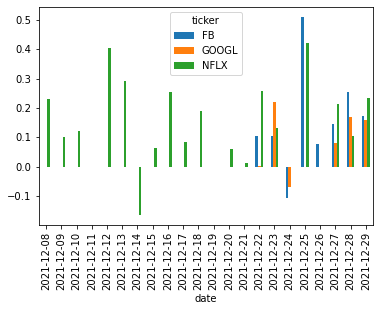

In [95]:
df["date"] = pd.to_datetime(df.date).dt.date
mean = df.groupby(["ticker","date"]).mean()

#unstack data 
mean = mean.unstack()
mean = mean.xs("compound", axis="columns").transpose()
mean.plot(kind="bar")
plt.show()